In [4]:
import pandas as pd
import numpy as np
import random
import re
import os
import json
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense, Masking, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
warnings.filterwarnings('ignore')       # 성가신 경고는 출력하지 않고 무시한다.

In [5]:
directory_path = r"C:\Users\user\Downloads\TL_QA_seoul"

json_data_list = []

for file_name in os.listdir(directory_path):
    if file_name.endswith(".json"):
        file_path = os.path.join(directory_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

                if 'images' in data:
                    del data['images']

                json_data_list.append(data)

                with open(file_path, 'w', encoding='utf-8') as file:
                    json.dump(data, file, ensure_ascii=False, indent=4)

        except FileNotFoundError:
            print(f"File {file_name} not found.")
        except json.JSONDecodeError:
            print(f"Error decoding JSON from file {file_name}.")

In [6]:
questions = []
answers = []

for item in json_data_list:
    if 'annotations' in item:
        for annotation in item['annotations']:
            if 'question' in annotation:
                for question in annotation['question']:
                    questions.append(question['question'])
                    answers.append(question['answer'])

print("Questions:", questions[:5])
print("Answers:", answers[:5])

Questions: ['이 곳의 주소를 알 수 있나요?', '이 곳의 주요 메뉴는 무엇이 있나요?', '이 곳에 인접한 시설이 있나요?', '주차시설이 있나요?', '이 곳의 주소는 어떻게 되나요?']
Answers: ['서울 강서구 우장산로16길 26', '생대구탕, 특대구탕', '강서구청, 커피바알아, 우리은행', '없음', '서울 강서구 우장산로16길 26']


In [7]:
my_data = pd.DataFrame({
    'Source': questions,
    'Target': answers
})

print(my_data)

                       Source             Target
0           이 곳의 주소를 알 수 있나요?  서울 강서구 우장산로16길 26
1        이 곳의 주요 메뉴는 무엇이 있나요?         생대구탕, 특대구탕
2           이 곳에 인접한 시설이 있나요?  강서구청, 커피바알아, 우리은행
3                  주차시설이 있나요?                 없음
4           이 곳의 주소는 어떻게 되나요?  서울 강서구 우장산로16길 26
...                       ...                ...
36055       이 곳의 주소를 알 수 있나요?  서울 동작구 동작대로35길 10
36056           연락처를 알 수 있나요?      070-8876-6424
36057              주차시설이 있나요?                 없음
36058          영업시간은 어떻게 되나요?      12:00 - 22:00
36059  이 곳의 대표적인 메뉴는 무엇이 있나요?        아메리카노, 카페라떼

[36060 rows x 2 columns]


In [9]:
# 단어 단위로 토큰화 하고, decoder 입력과 출력에 필요한 Target에는 <sos>태그와 <eos> 태그를 붙여준다.
my_src_in = []
my_tar_in = []
my_tar_out = []
for i in range(my_data.shape[0]):
    a_src = my_data.Source.loc[i].split()           # Encoder에 입력되는 Source는 있는 그대로 split해 둘 수 있다.
    a_tar = my_data.Target.loc[i]
    a_tar_in = [a_word for a_word in ('<sos> ' + a_tar).split()]
    a_tar_out = [a_word for a_word in (a_tar + ' <eos>').split()]
    my_src_in.append(a_src)
    my_tar_in.append(a_tar_in)
    my_tar_out.append(a_tar_out)

In [10]:
# 정수 인코딩 Source.
my_tokenizer_src = Tokenizer()
my_tokenizer_src.fit_on_texts(my_src_in)
my_encoder_in = my_tokenizer_src.texts_to_sequences(my_src_in)

# 정수 인코딩 Target. In과 Out 별도
my_tokenizer_tar = Tokenizer()
my_tokenizer_tar.fit_on_texts(my_tar_in)         # 학습.
my_tokenizer_tar.fit_on_texts(my_tar_out)        # 추가 학습.
my_decoder_in = my_tokenizer_tar.texts_to_sequences(my_tar_in)
my_decoder_out = my_tokenizer_tar.texts_to_sequences(my_tar_out)

In [11]:
# 패딩.
my_encoder_in_pad = pad_sequences(my_encoder_in, padding='post')
my_decoder_in_pad = pad_sequences(my_decoder_in, padding='post')
my_decoder_out_pad = pad_sequences(my_decoder_out, padding='post')

In [12]:
# 다음과 같이 tar_in에만 들어있는 '<sos>'와 '<eos>'가 제대로 학습되었음을 확인해 본다.
print( my_tokenizer_tar.word_index['<sos>'] )
print( my_tokenizer_tar.word_index['<eos>'] )

1
2


In [13]:
# Vocabulary 크기.
SRC_VOCAB_SIZE = len(my_tokenizer_src.word_index) + 1     # 0이 패딩용으로 추가되어 +1.
TAR_VOCAB_SIZE = len(my_tokenizer_tar.word_index) + 1     # 0이 패딩용으로 추가되어 +1.
print('Source vocabulary size : {:d}, Target vocabulary size : {:d}'.format(SRC_VOCAB_SIZE, TAR_VOCAB_SIZE))

Source vocabulary size : 162, Target vocabulary size : 9413


In [14]:
# 변환 사전을 간추려 둔다.
src_to_index = my_tokenizer_src.word_index
index_to_src = my_tokenizer_src.index_word

tar_to_index = my_tokenizer_tar.word_index
index_to_tar = my_tokenizer_tar.index_word

In [16]:
# 데이터 쪼개기 준비.
idx = list(range(my_data.shape[0]))
random.shuffle(idx)
my_encoder_in_pad = my_encoder_in_pad[idx]
my_decoder_in_pad = my_decoder_in_pad[idx]
my_decoder_out_pad = my_decoder_out_pad[idx]

In [18]:
n_data = len(my_data)  # my_data의 길이를 가져옵니다.
n_train = int(n_data * 0.8)  # 데이터의 80%를 학습 데이터로 사용합니다.
n_test = n_data - n_train
my_encoder_in_train = my_encoder_in_pad[:n_train]
my_decoder_in_train = my_decoder_in_pad[:n_train]
my_decoder_out_train = my_decoder_out_pad[:n_train]

my_encoder_in_test = my_encoder_in_pad[-n_train:]
my_decoder_in_test = my_decoder_in_pad[-n_train:]
my_decoder_out_test = my_decoder_out_pad[-n_train:]

In [19]:
N_EMBEDDING = 50                   # Embedding 차원의 크기 정의.
N_HIDDEN = 64                      # 은닉 차원의 수.

In [20]:
# 인코더 Layer 정의.
# 부모 클래스 Layer를 상속받아서 정의된다.

# 향후 저장과 로딩이 용이하도록 데코레이터 적용.
@register_keras_serializable()
class Encoder(Layer):

# 층 구조를 정의한다.
  def __init__(self, vocab_size, n_embedding, n_hidden):
    super(Encoder, self).__init__()                                   # 부모 클래스의 생성자 함수 호출.
    self.vocab_size = vocab_size
    self.n_embedding = n_embedding
    self.n_hidden = n_hidden
    self.embedding = Embedding(self.vocab_size, self.n_embedding)     # Embedding 층. 정수 1개씩 입력 전제.
    self.masking = Masking(mask_value=0.0)                            # 패딩 0은 연산에서 제외. 해당 스텝은 스킵한다.
    self.lstm = LSTM(units = self.n_hidden, return_state=True)        # 최종 상태값 반환을 위해 return_state=True. 은닉 상태와 셀 상태 반환.

# 객체가 호출될 때 실제 사용되는 함수.
  def call(self, x):
    x = self.embedding(x)
    x = self.masking(x)
    _ , state_h, state_c = self.lstm(x)
    return [state_h, state_c]                                         # 최종 상태만 반환.

In [21]:
# 디코더 Layer 정의.
# 부모 클래스 Layer를 상속받아서 정의된다.

# 향후 저장과 로딩이 용이하도록 데코레이터 적용.
@register_keras_serializable()
class Decoder(Layer):

# 층 구조를 정의한다.
  def __init__(self, vocab_size, n_embedding, n_hidden):
    super(Decoder, self).__init__()                                   # 부모 클래스의 생성자 함수 호출.
    self.vocab_size = vocab_size
    self.n_embedding = n_embedding
    self.n_hidden = n_hidden
    self.embedding = Embedding(self.vocab_size, self.n_embedding)     # Embedding 층. 정수 1개씩 입력 전제.
    self.masking = Masking(mask_value=0.0)                            # 패딩 0은 연산에서 제외. 해당 스텝은 스킵한다.
    self.lstm = LSTM(units=self.n_hidden, return_sequences=True, return_state=True) # 상태값 리턴을 위해 return_state=True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True.
    self.dense = Dense(units=self.vocab_size, activation='softmax')   # 모든 시점의 결과에 대해서 소프트맥스 함수를 적용하는 출력층을 통해 단어 예측.

# 객체가 호출될 때 실제 사용되는 함수.
  def call(self, x, prev_states):
    x = self.embedding(x)
    x = self.masking(x)
    decoder_outputs, _, _ = self.lstm(x, initial_state=prev_states)     # initial_state에 주목한다. 출력된 state_h, state_c는 그대로 버린다.
    x = self.dense(decoder_outputs)
    return x

In [22]:
# Seq2Seq 정의.
# 부모 클래스 Model를 상속받아서 정의된다.

# 향후 저장과 로딩이 용이하도록 데코레이터 적용.
@register_keras_serializable()
class Seq2Seq(Model):
  def __init__(self, src_vocab_size, tar_vocab_size, n_embedding, n_hidden):
    super(Seq2Seq, self).__init__()                                   # 부모 클래스의 생성자 함수 호출.
    self.encoder = Encoder(src_vocab_size, n_embedding, n_hidden)     # 인코더 객체 생성.
    self.decoder = Decoder(tar_vocab_size, n_embedding, n_hidden)     # 디코더 객체 생성.

  def call(self, x):
    encoder_inputs , decoder_inputs = x                               # 입력을 세분화 한다.
    encoder_states = self.encoder(encoder_inputs)                     # 인코더의 최종 상태를 만든다.
    decoder_outputs = self.decoder(decoder_inputs, encoder_states )   # 인코더의 최종 상태를 입력해서 디코더 실행.
    return decoder_outputs

  # 디코더 한 스텝씩 예측 처리해 주는 함수.
  def predict_one_step(self, encoder_inputs, decoder_input, decoder_initial_states=None):
    if not decoder_initial_states:                                    # decoder_initial_states가 입력되지 않았다면, 첫 번째 스텝이다.
      encoder_states = self.encoder(encoder_inputs)                   # 인코더의 최종 상태를 만든다.
      decoder_initial_states = encoder_states                         # 인코더의 최종 상태가 바로 디코더의 초기 상태.
    x = self.decoder.embedding(decoder_input)
    x = self.decoder.masking(x)
    decoder_outputs, state_h, state_c = self.decoder.lstm(x, initial_state=decoder_initial_states)
    decoder_probs = self.decoder.dense(decoder_outputs)               # 인덱스별 확률!
    return decoder_probs, state_h, state_c

In [23]:
# Seq2Seq 모델 객체 생성.
my_model = Seq2Seq(SRC_VOCAB_SIZE, TAR_VOCAB_SIZE, N_EMBEDDING, N_HIDDEN)

In [24]:
n_epochs = 500                    # Number of epochs.
batch_size = 128                  # Size of each batch.
learn_rate = 0.0005               # Learning rate.

In [25]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(optimizer=my_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # one-hot-encoding > 정수 인코딩(sparse하다)

In [27]:
# Train
callback1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  # 조기 종료 허락
callback2 = ModelCheckpoint(filepath='./models/seq2seq_01.keras', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)  # 최적 모델 저장

my_summary = my_model.fit(
    x=[my_encoder_in_train, my_decoder_in_train], 
    y=my_decoder_out_train, 
    validation_data=([my_encoder_in_test, my_decoder_in_test], my_decoder_out_test), 
    batch_size=batch_size, 
    epochs=n_epochs, 
    callbacks=[callback1, callback2], 
    verbose=0
)

Epoch 223: early stopping


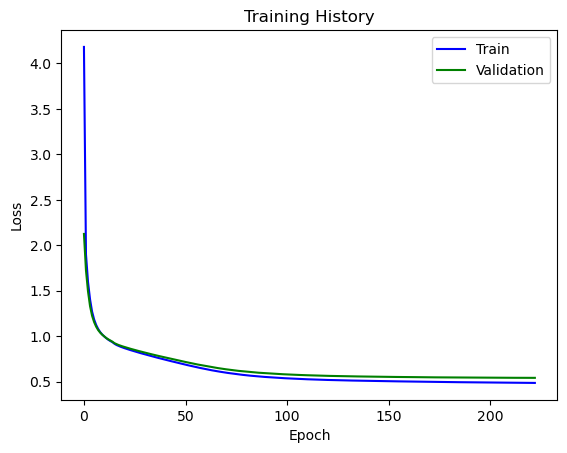

In [28]:
# 학습 history 출력.
plt.plot(my_summary.history['loss'], c='b')
plt.plot(my_summary.history['val_loss'], c='g')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [29]:
# 디코더를 사용해서 예측해 주는 헬퍼 함수.
MAX_SEQUENCE = 30                         # 문장의 최대 길이.
def decode_sequence(input_seq):

    # <sos>에 해당하는 정수 생성. 디코더의 시작점을 의미한다.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 스텝 한개씩 반복한다. batch_size = 1로 설정해서 단순화 한다.
    # 다음은 인코더의 최종 상태를 디코더의 초기 상태로 받겠다는 의미.
    initial_states = None
    while not stop_condition:
        # <sos>와 이전 시점의 상태 initial_states를 현 시점의 초기 상태로 사용한다.
        probs, h, c = my_model.predict_one_step(input_seq, target_seq, initial_states)

        # 현 스텝에서 출력된 상태를 다음 스텝의 입력으로 사용하기 위해서 저장해 둔다.
        initial_states = [h, c]

        # 예측 결과를 단어로 변환한다.
        # 유일한 타임 스텝의 (확률) 출력 벡터에서 argmax로 해당 인덱스를 가져온다.
        pred_index = np.argmax(probs[0, -1, :])

        # 인덱스를 단어로 변환해 준다.
        pred_word = index_to_tar[pred_index]

        # <eos>에 도달 또는 최대 길이 초과시 중단.
        if (pred_word == '<eos>' or len(decoded_sentence) >= MAX_SEQUENCE):
          stop_condition = True
          continue

        # 예측된 단어를 결과 문장에 이어 붙인다.
        decoded_sentence += ' ' + pred_word

        # 현 스텝의 예측을 다음 스텝의 입력으로 사용하기 위해서 저장한다.
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = pred_index

    return decoded_sentence

In [30]:
# 정수 시퀀스를 Source 문장으로 변환해 주는 핼퍼 함수.
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i] + ' '
    return temp

# 정수 시퀀스를 Target 문장으로 변환해 주는 헬퍼 함수.
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [31]:
# 학습용 데이터를 다시 사용해서 예측 테스트.
for i in [random.randint(0,n_train-1) for _ in range(5)]:
    input_seq = my_encoder_in_train[i: i + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('Input sentence     :',seq2src(my_encoder_in_train[i]))
    print('Correct sentence   :',seq2tar(my_decoder_in_train[i]))
    print('Machine translated :',decoded_sentence)
    print('\n')

Input sentence     : 이 곳에 인접한 시설이 있나요? 
Correct sentence   : 아차산역 3번 출구 
Machine translated :  흑석역 4번 출구


Input sentence     : 이 곳의 주요 메뉴는 무엇이 있나요? 
Correct sentence   : 딸기잼, 카스테라 
Machine translated :  아메리카노, 카페라떼


Input sentence     : 이 곳에 인접한 시설이 있나요? 
Correct sentence   : 지하철 뚝섬역 8번 출구 
Machine translated :  흑석역 4번 출구


Input sentence     : 영업시간은 몇시부터 몇시까지로 기재되어 있나요? 
Correct sentence   : 10:00/11:00~22:00 
Machine translated :  알수없음


Input sentence     : 휴무일은 어떻게 되나요? 
Correct sentence   : 매주 월요일 
Machine translated :  없음




In [32]:
# 별도의 시험용 데이터를 사용해서 예측 테스트.
for i in [random.randint(0,n_test-1) for _ in range(5)]:
    input_seq = my_encoder_in_test[i: i + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('Input sentence     :',seq2src(my_encoder_in_test[i]))
    print('Correct sentence   :',seq2tar(my_decoder_in_test[i]))
    print('Machine translated :',decoded_sentence)
    print('\n')

Input sentence     : 주차시설이 있나요? 
Correct sentence   : 없음 
Machine translated :  있음


Input sentence     : 영업시간은 어떻게 되나요? 
Correct sentence   : 10:00-03:00 
Machine translated :  11:00 - 21:00


Input sentence     : 휴무일은 어떻게 되나요? 
Correct sentence   : 없음 
Machine translated :  없음


Input sentence     : 이 곳의 주요 메뉴는 무엇이 있나요? 
Correct sentence   : 필터커피, 에스프레소 
Machine translated :  아메리카노, 카페라떼


Input sentence     : 이 곳의 대표적인 메뉴를 알 수 있나요? 
Correct sentence   : 범전골, 백계 
Machine translated :  아메리카노, 카페라떼


